# Random Forest

- skip_exec: true


What is a random forest?

- A universal machine learning algorithm that can be used for both classification and regression problems.
- A way of predicting something of any kind. It could be a category or a continuous value.
- It can predict it with columns of any kind. The columns could contain data about pixels, postcodes, revenue, etc.
- It is very resistant to overfitting, and where it does overfit, it is easy to fix.
- It does not require a separate validation set. In general, it can tell you how well it generalises even if you only have one data set.
- It has few if any statistical assumptions about the data. E.g. it does not assume that the data is normally distributed, that the data is linear, that the data is balanced, etc.
- It does not require lots of feature engineering.

The curse of dimensionality is a largely meaningless concept in machine learning. The idea is having more columns creates a space that is more "empty" because the more dimensions you have the likelier it is that a point sits on the edge of a particular dimension. In theory this means that the distance between points is less meaningful in higher dimensions. This isn't actually a problem. Points do still have meaniful distances across other dimensions so you can still say one point is more or less similar to another. So e.g. K nearest neighbours still works fine in high dimensions. The curse of dimensionality is a problem in statistics, but not in machine learning.

In fact when doing feature engineering for machine learning you should add columns if they contain any information that could be useful to your model.


## Implementation


In [ ]:
import math
import re

import numpy as np
import pandas as pd
from fastai.tabular.all import add_datepart, cont_cat_split, Categorify, FillMissing, TabularPandas
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
import graphviz
import IPython
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz

In [ ]:
pd.set_option('display.max_columns', None)
# np.random.seed(42)
set_config(transform_output="pandas")

In [ ]:
def rmse(x, y):
    return math.sqrt(((x - y) ** 2).mean())

In [ ]:
df = pd.read_csv(f"../data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])
df["SalePrice"] = np.log(df["SalePrice"])

In [ ]:
idxs = sorted(np.random.permutation(len(df)))
df = df.iloc[idxs].copy()

In [ ]:
cond = (df["saledate"] < "2011-10-01")
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx), list(valid_idx))

In [ ]:
df["ProductSize"] = df["ProductSize"].astype("category")
df["ProductSize"] = df["ProductSize"].cat.set_categories(
    ["Compact", "Mini", "Small", "Medium", "Large / Medium", "Large"], ordered=True
)

df["UsageBand"] = df["UsageBand"].astype("category")
df["UsageBand"] = df["UsageBand"].cat.set_categories(["Low", "Medium", "High"], ordered=True)

df["datasource"] = df["datasource"].astype("category")

### FastAI Data Pipeline


In [ ]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    res = {
        "Train RMSE": rmse(m.predict(X_train), y_train),
        "Valid RMSE": rmse(m.predict(X_valid), y_valid),
        "Train r^2": m.score(X_train, y_train),
        "Valid r^2": m.score(X_valid, y_valid),
    }
    print(m.oob_score_)
    if hasattr(m, "oob_score_"):
        res["OOB score"] = m.oob_score_
    print(res)

In [ ]:
fa_df = df.copy()

In [ ]:
fa_df = add_datepart(fa_df, "saledate", drop=True)

In [ ]:
conts, cats = cont_cat_split(fa_df, max_card=3, dep_var="SalePrice")

Categorical variables are made up of discrete levels, such as gender or product type for which addition and multiplication don't have meaning (even if they're stored as numbers). To use them in the model though we need to convert them to numbers.


In [ ]:
procs = [Categorify, FillMissing]

In [ ]:
to = TabularPandas(fa_df, procs, cats, conts, y_names="SalePrice", splits=splits)

In [ ]:
rf_to = RandomForestRegressor(
    # random_state=42,
    n_jobs=-1,
    n_estimators=100,
    max_features=0.5,
    min_samples_leaf=3,
    bootstrap=True,
    oob_score=True,
)
rf_to.fit(to.train.xs, to.train.y)

print_score(rf_to, to.train.xs, to.train.y, to.valid.xs, to.valid.y)

0.9160049235233902
{'Train RMSE': 0.11724787747755416, 'Valid RMSE': 0.23726778206610594, 'Train r^2': 0.9713636957103372, 'Valid r^2': 0.8945266953725043, 'OOB score': 0.9160049235233902}


### Scikit-Learn data pipeline


In [ ]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    res = {
        "Train RMSE": rmse(m.predict(X_train), y_train),
        "Valid RMSE": rmse(m.predict(X_valid), y_valid),
        "Train r^2": m.score(X_train, y_train),
        "Valid r^2": m.score(X_valid, y_valid),
    }
    if hasattr(m["classifier"], "oob_score_"):
        res["OOB score"] = m["classifier"].oob_score_
    print(res)

In [ ]:
sk_df = df.copy()

In [ ]:
def add_datepart(df: pd.DataFrame, column_name: str, drop: bool = False) -> pd.DataFrame:
    prefix = re.sub("[Dd]ate$", "", column_name)
    attr = [
        "Year",
        "Month",
        "Week",
        "Day",
        "Dayofweek",
        "Dayofyear",
        "Is_month_end",
        "Is_month_start",
        "Is_quarter_end",
        "Is_quarter_start",
        "Is_year_end",
        "Is_year_start",
    ]
    col = df[column_name]
    week = (
        col.dt.isocalendar().week.astype(col.dt.day.dtype) if hasattr(col.dt, "isocalendar") else col.dt.week
    )
    for n in attr:
        df[f"{prefix}{n}"] = getattr(col.dt, n.lower()) if n != "Week" else week
    df[prefix + "Elapsed"] = np.where(~col.isna(), col.values.astype(np.int64) // 10 ** 9,np.nan)
    if drop:
        df = df.drop(column_name, axis=1)
    return df

def cont_cat_split(df, max_card=2, dep_var=None):
    "Helper function that returns column names of cont and cat variables from given `df`."
    cont_names, cat_names = [], []
    for label in df:
        if label == dep_var:
            continue
        if (
            pd.api.types.is_integer_dtype(df[label].dtype) and df[label].unique().shape[0] > max_card
        ) or pd.api.types.is_float_dtype(df[label].dtype):
            cont_names.append(label)
        else:
            cat_names.append(label)
    return cont_names, cat_names

In [ ]:
sk_df = add_datepart(sk_df, "saledate", drop=True)

In [ ]:
conts, cats = cont_cat_split(sk_df, max_card=3, dep_var="SalePrice")

In [ ]:
sk_df_train = sk_df.iloc[train_idx].copy()
sk_df_valid = sk_df.iloc[valid_idx].copy()

In [ ]:
preprocessing = ColumnTransformer(
    [
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1), cats),
        ("num", SimpleImputer(strategy="mean", add_indicator=True), conts),
    ],
    verbose_feature_names_out=False,
)

In [ ]:
rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestRegressor(random_state=42, n_jobs=-1)),
    ]
)
rf.fit(sk_df_train.drop("SalePrice", axis=1), sk_df_train["SalePrice"])

print_score(
    rf,
    sk_df_train.drop("SalePrice", axis=1),
    sk_df_train["SalePrice"],
    sk_df_valid.drop("SalePrice", axis=1),
    sk_df_valid["SalePrice"],
)

{'Train RMSE': 0.07564979583541039, 'Valid RMSE': 0.2501823172602292, 'Train r^2': 0.9880787299789497, 'Valid r^2': 0.8827323440727398}


## Visualising the tree

In [ ]:
drawable_rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestRegressor(n_jobs=-1, n_estimators=1, max_depth=3, bootstrap=False)),
    ]
)
drawable_rf.fit(sk_df_train.drop("SalePrice", axis=1), sk_df_train["SalePrice"])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['datasource', 'UsageBand',
                                                   'fiModelDesc', 'fiBaseModel',
                                                   'fiSecondaryDesc',
                                                   'fiModelSeries',
                                                   'fiModelDescriptor',
                                                   'ProductSize',
                                                   'fiProductClassDesc',
                                                   'state', 'ProductGroup',
                                                   'ProductGroupDesc',
                                                   'Dr...
                                                  SimpleImputer(add_indicator=True),
                                                  ['SalesID', 'MachineID',
                                                   'ModelID', 'auctioneerID',
                                                   'YearMade',
                                                   'MachineHoursCurrentMeter',
                                                   'saleYear', 'saleMonth',
                                                   'saleWeek', 'saleDay',
                                                   'saleDayofweek',
                                                   'saleDayofyear',
                                                   'saleElapsed'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestRegressor(bootstrap=False, max_depth=3,
                                       n_estimators=1, n_jobs=-1,
                                       random_state=42))])

In [ ]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s = export_graphviz(
        t,
        out_file=None,
        feature_names=df.columns,
        filled=True,
        special_characters=True,
        # max_depth=3,
        rotate=True,
        precision=precision,
    )
    IPython.display.display(graphviz.Source(re.sub("Tree {", f"Tree {{ size={size}; ratio={ratio}", s)))

A decision tree consists of a sequence of binary decisions (or "splits"). We have 28588 samples at the beginning. The average price is 10.098. If we simply predicted the average price for everything the mean squared error would be 0.479. 

The split that reduces the error by the greatest amount is `Coupler_System <= -0.5`. Doing this split reduces the error to 0.113 in the group of 3140 rows where `Coupler_System <= -0.5` and to 0.412 in the group of 25448 rows where `Coupler_System > -0.5`.

The model determines how good a split is by taking the average mse of the two groups created by the split, weighted by the number of rows in each group. The average mse of the two groups is 0.113 * 3140/28588 + 0.412 * 25448/28588 = 0.379. This is the error that would be achieved if we used this split to predict the price of every row in the data set.

How many possible splits does the model have to test? Boolean columns have only possible values. So the model would only have to test `boolean_col <= 0.5`. For columns with more unique values, the model would also try splits between each of those values.

The model will continue to split the a group until it only has 1 value in it unless declare a minimum group size that is greater than this. In scikit-learn this is the `min_samples_leaf` parameter. We could also explicitly set a maximum number of splits using the `max_depth` parameter.

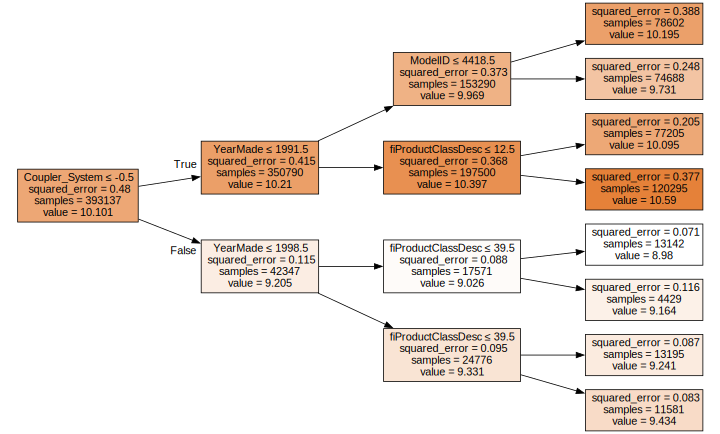

In [ ]:
draw_tree(
    drawable_rf["classifier"].estimators_[0],
    preprocessing.transform(sk_df_valid.drop("SalePrice", axis=1)),
    precision=3,
)

If we do not set a maximum depth or minimum leaf size, the model will continue to split until it has 1 value in each leaf. Because at that point it is able to perfectly predict the value of every row in the training data, the error will be 0. At this point the decision tree will almost certainly have overfit to the training data and will not generalise well to new data.

In [ ]:
overfit_decision_tree = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=1, bootstrap=False)),
    ]
)
overfit_decision_tree.fit(sk_df_train.drop("SalePrice", axis=1), sk_df_train["SalePrice"])

print_score(
    overfit_decision_tree,
    sk_df_train.drop("SalePrice", axis=1),
    sk_df_train["SalePrice"],
    sk_df_valid.drop("SalePrice", axis=1),
    sk_df_valid["SalePrice"],
)

{'Train RMSE': 9.883335585478044e-17, 'Valid RMSE': 0.37889885300613685, 'Train r^2': 1.0, 'Valid r^2': 0.7310251935047887}


We would like to allow the decision tree to grow so they can capture lots of interactions but we don't want them to overfit. This is the motivation behind random forests which are an ensemble of decision trees.

Each decision tree in a random forest is somewhat predictive. It is also only slightly correlated with the other trees in the forest. The reason the trees are only slightly correlated with each other is because each tree is trained on a random sub sample of the data. Each decision tree can be allowed to overfit on its sub sample because its errors will not be correlated with the errors of the other trees. After averaging out the errors we will be left with the true relationship between the features and the target.

In [ ]:
rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestRegressor(n_jobs=-1, n_estimators=20, bootstrap=False)),
    ]
)
rf.fit(sk_df_train.drop("SalePrice", axis=1), sk_df_train["SalePrice"])

print_score(
    rf,
    sk_df_train.drop("SalePrice", axis=1),
    sk_df_train["SalePrice"],
    sk_df_valid.drop("SalePrice", axis=1),
    sk_df_valid["SalePrice"],
)

{'Train RMSE': 2.727672741251521e-15, 'Valid RMSE': 0.35216771746998304, 'Train r^2': 1.0, 'Valid r^2': 0.7676385341173853}


In [ ]:
rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", ExtraTreesRegressor(n_jobs=-1, n_estimators=30, bootstrap=False)),
    ]
)
rf.fit(sk_df_train.drop("SalePrice", axis=1), sk_df_train["SalePrice"])

print_score(
    rf,
    sk_df_train.drop("SalePrice", axis=1),
    sk_df_train["SalePrice"],
    sk_df_valid.drop("SalePrice", axis=1),
    sk_df_valid["SalePrice"],
)

{'Train RMSE': 3.976779256978654e-15, 'Valid RMSE': 0.25358185835061997, 'Train r^2': 1.0, 'Valid r^2': 0.8795237661011207}


## Out of Bag (OOB) Score

It is possible to get an estimate of the generalisation error of a random forest without using a validation set. The OOB score is the average error of the predictions made by each tree on the rows that were not used to train that tree.

In [ ]:
rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestRegressor(n_jobs=-1, n_estimators=100, bootstrap=True, oob_score=True)),
    ]
)
rf.fit(sk_df_train.drop("SalePrice", axis=1), sk_df_train["SalePrice"])

print_score(
    rf,
    sk_df_train.drop("SalePrice", axis=1),
    sk_df_train["SalePrice"],
    sk_df_valid.drop("SalePrice", axis=1),
    sk_df_valid["SalePrice"],
)

{'Train RMSE': 0.0756497958354104, 'Valid RMSE': 0.2501823172602292, 'Train r^2': 0.9880787299789497, 'Valid r^2': 0.8827323440727398, 'OOB score': 0.9133581068838289}


In this case the OOB score is less than the score on the training set but better than the score for the out of time validation set which is what we'd expect.

## Hyperparameter Tuning

### Number of Estimators

A very easy hyperparameter to set. This is the number of decision trees in the random forest. Adding more will never make the model worse. It will just make it take longer to train. As you add more the marginal improvement will eventually get close 0. It's possible to plot this so just use as many estimators as it takes before the curve flattens out.

In [ ]:
preprocessing.transform(sk_df_valid.drop("SalePrice", axis=1))

,datasource,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,SalesID,MachineID,ModelID,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,missingindicator_auctioneerID,missingindicator_MachineHoursCurrentMeter
22915,0.0,1.0,2265.0,702.0,40.0,-1.0,-1.0,3.0,47.0,22.0,4.0,4.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,5.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,4.0,4.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1218822.0,1024652.0,4124.0,3.0,1000.0,6240.000000,2011.0,10.0,40.0,3.0,0.0,276.0,1.317600e+09,0.0,0.0
22916,0.0,2.0,272.0,99.0,47.0,-1.0,16.0,-1.0,1.0,47.0,0.0,0.0,1.0,5.0,0.0,1.0,0.0,0.0,7.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1218823.0,1067601.0,24808.0,3.0,2006.0,1802.000000,2011.0,10.0,40.0,6.0,3.0,279.0,1.317859e+09,0.0,0.0
22917,0.0,2.0,4418.0,1663.0,-1.0,-1.0,-1.0,-1.0,40.0,47.0,2.0,2.0,-1.0,5.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1218824.0,1010582.0,9580.0,3.0,2006.0,1926.000000,2011.0,10.0,40.0,6.0,3.0,279.0,1.317859e+09,0.0,0.0
22918,0.0,1.0,4127.0,1480.0,-1.0,-1.0,-1.0,-1.0,43.0,0.0,2.0,2.0,-1.0,5.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1218825.0,1026609.0,6270.0,3.0,2003.0,1340.000000,2011.0,10.0,40.0,6.0,3.0,279.0,1.317859e+09,0.0,0.0
22919,0.0,2.0,4548.0,1750.0,20.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,1.0,0.0,0.0,7.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1218826.0,1032638.0,17976.0,3.0,2007.0,2297.000000,2011.0,10.0,40.0,6.0,3.0,279.0,1.317859e+09,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,3.0,-1.0,478.0,157.0,105.0,-1.0,-1.0,4.0,12.0,43.0,3.0,3.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,11.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,-1.0,1.0,18.0,28.0,2.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,6333344.0,1919201.0,21435.0,2.0,2005.0,3401.025748,2012.0,3.0,10.0,7.0,2.0,67.0,1.331078e+09,0.0,1.0
412694,3.0,-1.0,479.0,157.0,105.0,62.0,-1.0,4.0,16.0,8.0,3.0,3.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,-1.0,1.0,18.0,28.0,2.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,6333345.0,1882122.0,21436.0,2.0,2005.0,3401.025748,2012.0,1.0,4.0,28.0,5.0,28.0,1.327709e+09,0.0,1.0
412695,3.0,-1.0,478.0,157.0,105.0,-1.0,-1.0,4.0,12.0,8.0,3.0,3.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,-1.0,0.0,18.0,28.0,2.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,6333347.0,1944213.0,21435.0,2.0,2005.0,3401.025748,2012.0,1.0,4.0,28.0,5.0,28.0,1.327709e+09,0.0,1.0
412696,3.0,-1.0,478.0,157.0,105.

In [ ]:
n_estimators_preds = np.stack(
    [
        t.predict(preprocessing.transform(sk_df_valid.drop("SalePrice", axis=1)).values)
        for t in rf["classifier"].estimators_
    ]
)

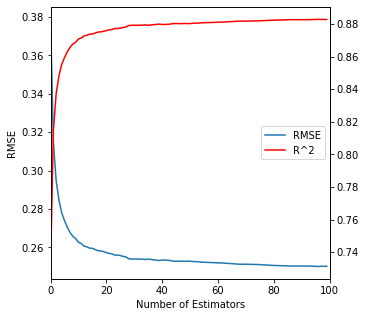

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(
    [
        rmse(np.mean(n_estimators_preds[: i + 1], axis=0), sk_df_valid["SalePrice"])
        for i in range(len(rf["classifier"].estimators_))
    ],
    label="RMSE",
)
ax.set_xlim(0, len(rf["classifier"].estimators_))
ax.set_xmargin(0)
ax.set_ymargin(0)
ax.set_xlabel("Number of Estimators")
ax.set_ylabel("RMSE")

ax2 = ax.twinx()
ax2.plot(
    [
        r2_score(sk_df_valid["SalePrice"], np.mean(n_estimators_preds[: i + 1], axis=0))
        for i in range(len(rf["classifier"].estimators_))
    ],
    color="red",
    label="R^2",
)


plt.legend([ax.get_lines()[0], ax2.get_lines()[0]], ["RMSE", "R^2"], loc="center right")
plt.show()

### Minimum Samples Per Leaf

The minimum number of samples in a leaf. Setting this to a number greater than 1 reduces the number of decisions each tree has to make so we can train faster. It also means each tree will generalise better but be less powerful on its own.

In [ ]:
rf = Pipeline(
    [
        ("preprocess", preprocessing),
        (
            "classifier",
            RandomForestRegressor(
                n_jobs=-1, n_estimators=100, min_samples_leaf=3, bootstrap=True, oob_score=True
            ),
        )
    ]
)
rf.fit(sk_df_train.drop("SalePrice", axis=1), sk_df_train["SalePrice"])

print_score(
    rf,
    sk_df_train.drop("SalePrice", axis=1),
    sk_df_train["SalePrice"],
    sk_df_valid.drop("SalePrice", axis=1),
    sk_df_valid["SalePrice"],
)

{'Train RMSE': 0.11328677219163683, 'Valid RMSE': 0.24638316963792045, 'Train r^2': 0.9732659097245269, 'Valid r^2': 0.8862668419317054, 'OOB score': 0.9122281641434296}


### Maximum Features

We want our trees to be as uncorrelated as possible. We could imagine a feauture that was especially predictive though. If every tree begins by splitting on this feature they will end up looking quite similar. We might not see certain interactions that are also important.

To avoid this we can, as well as using a random sample of rows, also use a random sample of columns. With row sampling, each new tree is trained on a different set of rows. With column sampling, at every binary split we choose from a different sample of columns.

The `max_features` parameter controls how many columns are used at each split. The default is `sqrt` which means the number of columns is the square root of the total number of columns. This is a good default. It is also possible to set it to a number or a fraction. If you set it to a number it will use that many columns. If you set it to a fraction it will use that fraction of the total number of columns.

In [ ]:
rf = Pipeline(
    [
        ("preprocess", preprocessing),
        (
            "classifier",
            RandomForestRegressor(
                n_jobs=-1,
                n_estimators=100,
                max_features=0.5,
                min_samples_leaf=3,
                bootstrap=True,
                oob_score=True,
            ),
        ),
    ]
)
rf.fit(sk_df_train.drop("SalePrice", axis=1), sk_df_train["SalePrice"])

print_score(
    rf,
    sk_df_train.drop("SalePrice", axis=1),
    sk_df_train["SalePrice"],
    sk_df_valid.drop("SalePrice", axis=1),
    sk_df_valid["SalePrice"],
)

{'Train RMSE': 0.11726977446387507, 'Valid RMSE': 0.23796931706918353, 'Train r^2': 0.9713529976118657, 'Valid r^2': 0.8939020601548652, 'OOB score': 0.9158260701022254}


An illustration of the relationship between `n_features` and `max_features` is scan be seen [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html). Reducing the `max_features` makes individual trees weaker but makes them more uncorrelated with each other. So as the number of trees increases the OOB score improves more for the lower `max_features` setting.

## Permutation Importance

In [ ]:
import rfpimp

In [ ]:
importances = rfpimp.importances(
    rf["classifier"], 
    preprocessing.transform(sk_df_valid.drop("SalePrice", axis=1)), 
    sk_df_valid["SalePrice"]
)

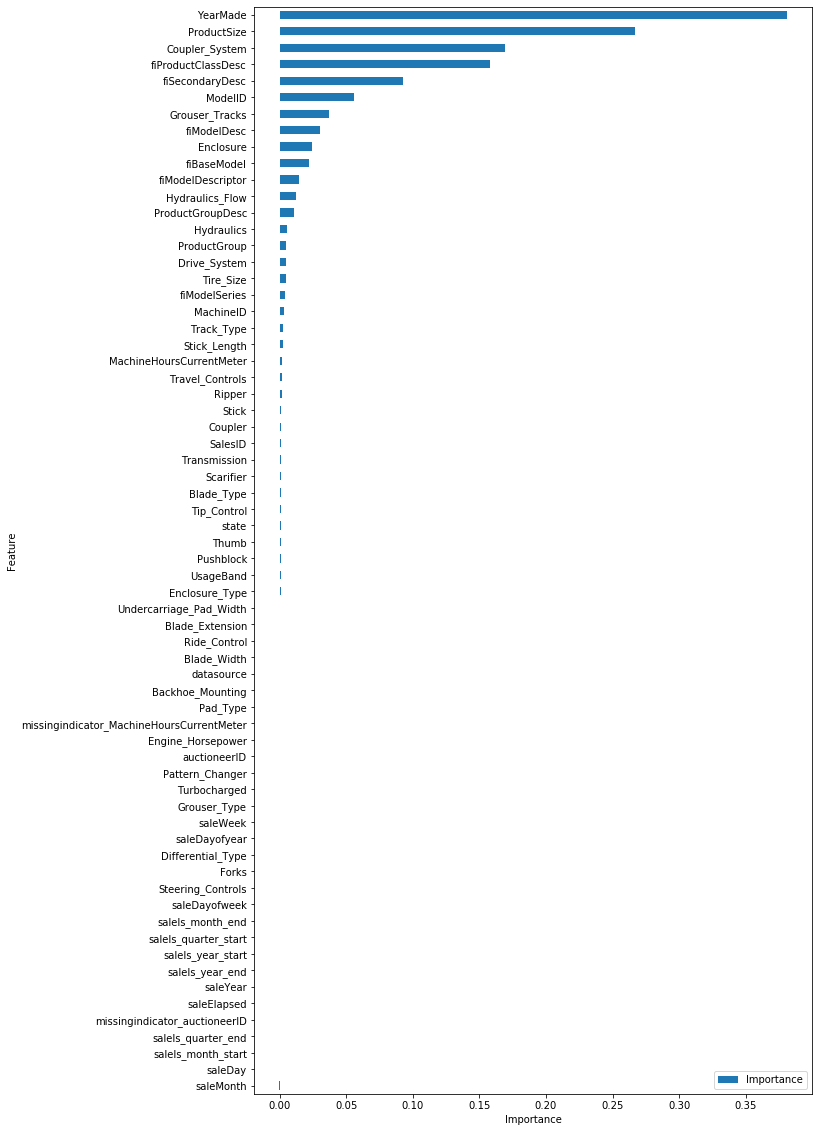

In [ ]:
fig, ax = plt.subplots(figsize=(10, 20))
importances.plot.barh(ax=ax)
ax.set_xmargin(0)
ax.set_ymargin(0)
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
ax.invert_yaxis()
plt.show()

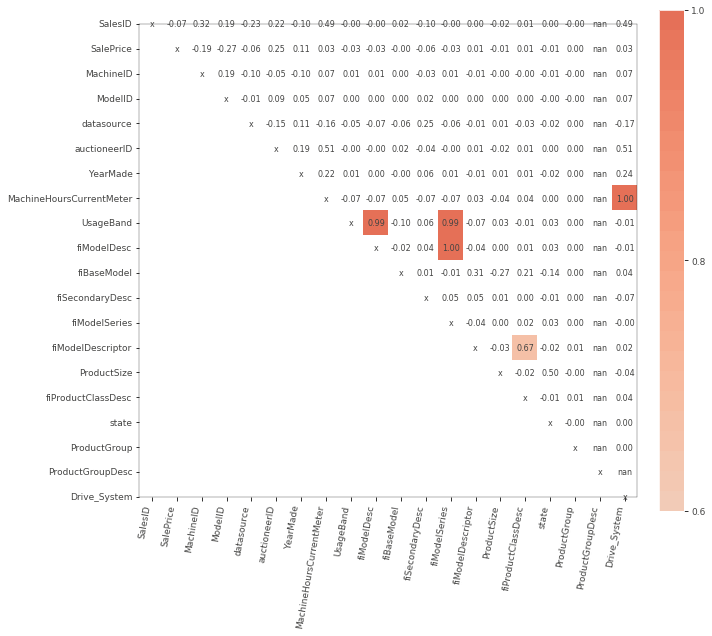

In [ ]:
viz = rfpimp.plot_corr_heatmap(sk_df_train, figsize=(10,10))

In [ ]:
fdm = rfpimp.feature_dependence_matrix(preprocessing.transform(sk_df_train.drop("SalePrice", axis=1)))

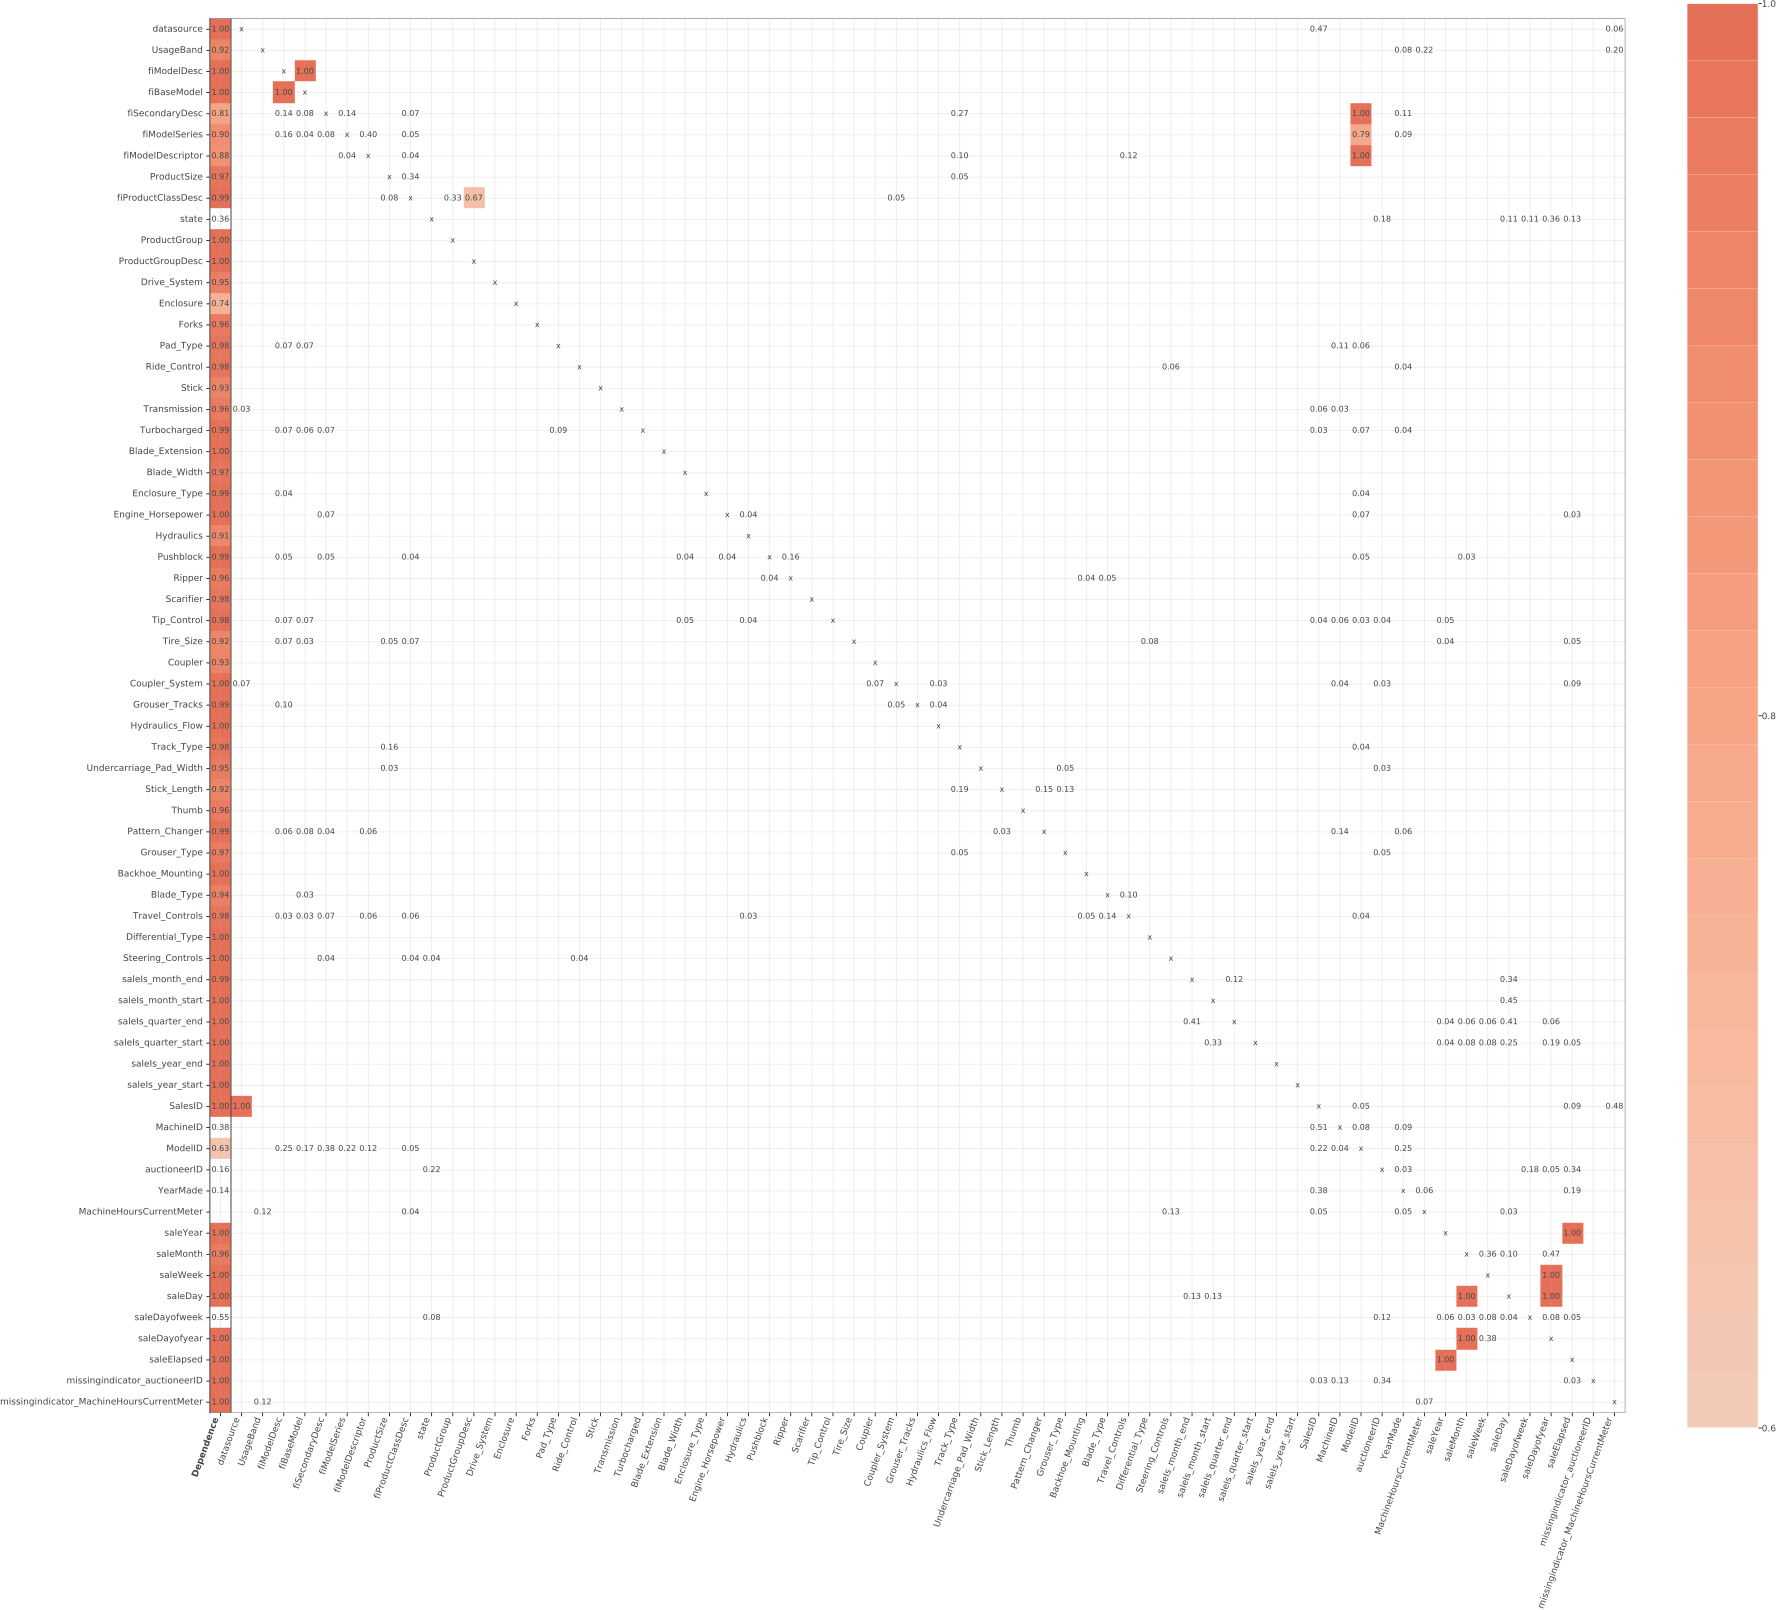

In [ ]:
rfpimp.plot_dependence_heatmap(fdm, figsize=(25,25))

In [ ]:
sk_df_train_imp = sk_df_train.drop(
    columns=[
        "SalesID",
        "fiBaseModel",
        "fiSecondaryDesc",
        "fiModelDescriptor",
        "saleElapsed",
        "saleDayofyear",
        "saleDay",
        "saleWeek",
    ]
)
sk_df_valid_imp = sk_df_valid.drop(
    columns=[
        "SalesID",
        "fiBaseModel",
        "fiSecondaryDesc",
        "fiModelDescriptor",
        "saleElapsed",
        "saleDayofyear",
        "saleDay",
        "saleWeek",
    ]
)  

In [ ]:
conts, cats = cont_cat_split(sk_df_train_imp, max_card=3, dep_var="SalePrice")

preprocessing = ColumnTransformer(
    [
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1), cats),
        ("num", SimpleImputer(strategy="mean", add_indicator=True), conts),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        (
            "classifier",
            RandomForestRegressor(
                n_jobs=-1,
                n_estimators=100,
                max_features=0.5,
                min_samples_leaf=3,
                bootstrap=True,
                oob_score=True,
            ),
        ),
    ]
)
rf.fit(sk_df_train_imp.drop("SalePrice", axis=1), sk_df_train_imp["SalePrice"])

print_score(
    rf,
    sk_df_train_imp.drop("SalePrice", axis=1),
    sk_df_train_imp["SalePrice"],
    sk_df_valid_imp.drop("SalePrice", axis=1),
    sk_df_valid_imp["SalePrice"],
)

{'Train RMSE': 0.13044584127385733, 'Valid RMSE': 0.24481597336683458, 'Train r^2': 0.9645539798198519, 'Valid r^2': 0.8877091100805693, 'OOB score': 0.9096183807330281}


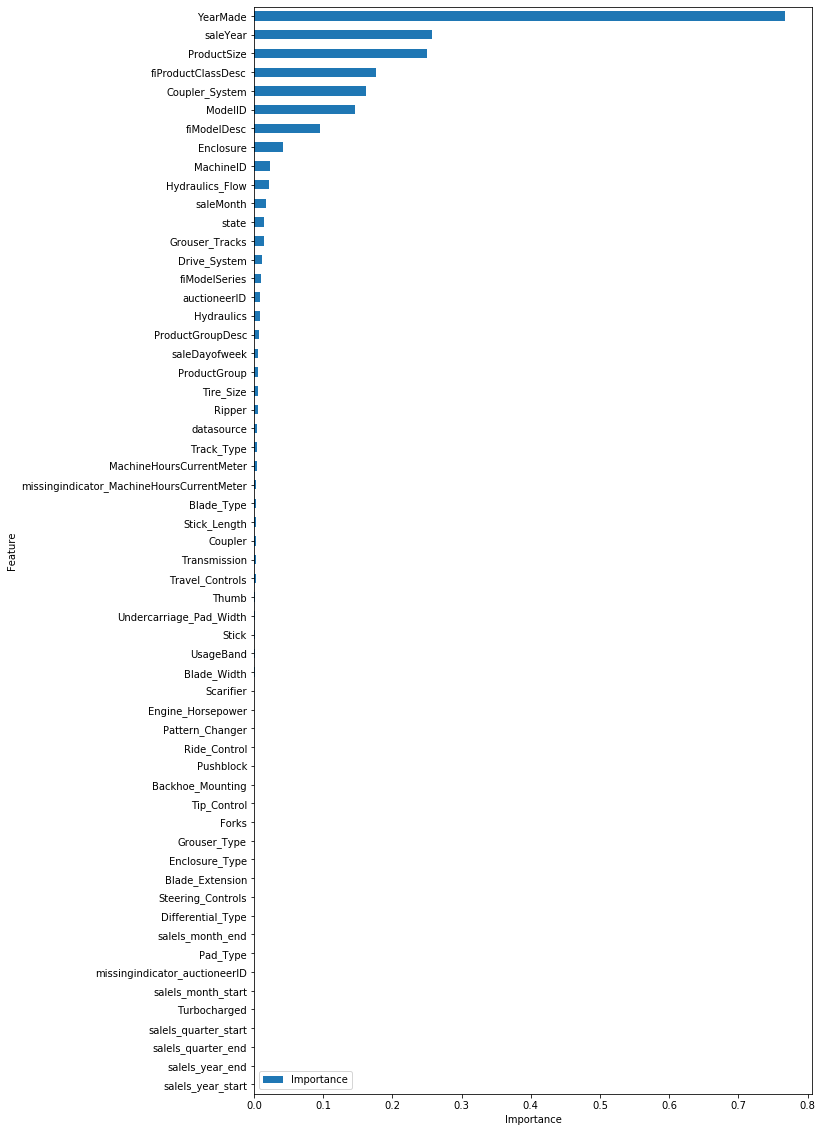

In [ ]:
importances = rfpimp.importances(
    rf["classifier"], 
    preprocessing.transform(sk_df_train_imp.drop("SalePrice", axis=1)), 
    sk_df_train_imp["SalePrice"]
)

fig, ax = plt.subplots(figsize=(10, 20))
importances.plot.barh(ax=ax)
ax.set_xmargin(0)
ax.set_ymargin(0)
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
ax.invert_yaxis()
plt.show()

In [ ]:
important_features = importances.iloc[:25].index

In [ ]:
conts, cats = cont_cat_split(sk_df_train_imp, max_card=3, dep_var="SalePrice")

preprocessing = ColumnTransformer(
    [
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1), cats),
        ("num", SimpleImputer(strategy="mean", add_indicator=True), conts),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        (
            "classifier",
            RandomForestRegressor(
                n_jobs=-1,
                n_estimators=100,
                max_features=0.5,
                min_samples_leaf=3,
                bootstrap=True,
                oob_score=True,
            ),
        ),
    ]
)
rf.fit(sk_df_train_imp, sk_df_train["SalePrice"])

print_score(
    rf,
    sk_df_train_imp,
    sk_df_train["SalePrice"],
    sk_df_valid_imp,
    sk_df_valid["SalePrice"],
)

{'Train RMSE': 0.1329281099591207, 'Valid RMSE': 0.24545006031144978, 'Train r^2': 0.9631921318986634, 'Valid r^2': 0.8871266775282887, 'OOB score': 0.90895357456373}


In [ ]:
conts, cats = cont_cat_split(sk_df_train_imp, max_card=3, dep_var="SalePrice")

preprocessing = ColumnTransformer(
    [
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1), cats),
        ("num", SimpleImputer(strategy="mean", add_indicator=True), conts),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        (
            "classifier",
            RandomForestRegressor(
                n_jobs=-1,
                n_estimators=100,
                max_features=0.5,
                min_samples_leaf=20,
                bootstrap=True,
                oob_score=True,
            ),
        ),
    ]
)
rf.fit(sk_df_train_imp, sk_df_train["SalePrice"])

print_score(
    rf,
    sk_df_train_imp,
    sk_df_train["SalePrice"],
    sk_df_valid_imp,
    sk_df_valid["SalePrice"],
)

{'Train RMSE': 0.2105525070888259, 'Valid RMSE': 0.25934193691691476, 'Train r^2': 0.9076519268078268, 'Valid r^2': 0.8739884009302059, 'OOB score': 0.8918486788207942}
